# Pacchetti

In [1]:
import pyBspline as Bs
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import scipy
from scipy.misc import derivative
from scipy.optimize import curve_fit
import pandas as pd
import copy
import pandas as pd
import os
import scipy.special
import re
import FFT as esFFT
from imp import reload 

###
def norm(x):
    return np.sqrt(np.sum(np.power(x,2.0)))   

In [2]:
#
def plot_sol(fig,n,xB,yB,x,y,c,title):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return

In [3]:
#
def plot_sol_disc(fig,n,xB_arr,yB_arr,x,y,c,title,cmap):
    
    ax = fig.add_subplot(n)
    for xB,yB in zip(xB_arr,yB_arr):
        ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    #ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return

In [4]:
#
def plot_matrix(sm,file_png=None):
    #
    sm2 = sm.copy()
    sm2["index"] = sm2.index
    #
    new = sm2.melt(id_vars=['index'])# = sm.index
    #
    new2 = new.copy()
    new2["index"] = [ i[0] for i in new2["index"]]
    new2["variable"] = [ i[0] for i in new2["variable"]]
    #new2["value"] = [np.complex(i) for i in new2["value"] ]
    new2["real"] = np.real(new2["value"])
    new2["imag"] = np.imag(new2["value"])
    new2["abs"] = np.absolute(new2["value"])
    new2["phase"] = np.angle(new2["value"])/np.pi
    df = new2
    
    #
    fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

    cmap = 'RdYlBu'

    #
    ax = fig.add_subplot(221)
    sc = ax.scatter(df["index"],df["variable"],c=df["real"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : real")

    #
    ax = fig.add_subplot(222)
    sc = ax.scatter(df["index"],df["variable"],c=df["imag"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : imag")

    #
    ax = fig.add_subplot(223)
    sc = ax.scatter(df["index"],df["variable"],c=df["abs"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : abs")

    #
    ax = fig.add_subplot(224)
    sc = ax.scatter(df["index"],df["variable"],c=df["phase"],cmap = 'RdYlBu')
    plt.colorbar(sc)
    plt.xlim(min(df["index"]),max(df["index"]))
    plt.ylim(min(df["index"]),max(df["index"]))
    ax.set_aspect('equal')
    plt.title("stiffness matrix : $\\theta / \pi$")

    plt.tight_layout()
    if file_png is not None :
        plt.savefig(file_png)
    plt.show()
    

# Young

## Definition

In [5]:
k_in = 30*np.asarray([1,0])
wavevector = 30#np.sqrt(np.sum(np.power(k_in,2.0)))
print("|k_in|:",norm(k_in))
print("w:",wavevector)
print("h:",np.pi/(5*wavevector))
print("lambda:",2*np.pi/wavevector)
I = np.complex(0,1)


xmin = -0.2
xmax = 4
ymin = -7
ymax = 7

|k_in|: 30.0
w: 30
h: 0.020943951023931952
lambda: 0.20943951023931953


In [6]:
#definisco la dimensionaità:
sh = Bs.shape(1,2)
#sh.show()

#defiisco i knot vector
P=1 #polinomial degree
N=10 #base caridnality
xminBs = 0.0
xmaxBs = 1.0


#
#kv = Bs.uniform_open_kv(xmin,xmax,p=P,n=N)#Bs.knot_vector(P,N,v)
#kv = periodic_kv(xmin,xmax,p=P,n=N)
kv = Bs.periodic_kv(xminBs,xmaxBs,p=P,n=N)
#kv.show()

#alloco la Bspline
bs = Bs.Bspline(sh,[kv],properties={"periodic":[True]})
#center = Bs.Bspline(sh,[kv],properties={"periodic":[True]})
#down = Bs.Bspline(sh,[kv],properties={"periodic":[True]})

#questo lo definisco dopo
#bs_arr = [bs,bs,bs]

In [7]:
file_dir = "files/BEM/Young-2/"
suffixPNK = "P="+str(P)+"-N="+str(N)+"-k="+str(wavevector)#+".csv"
suffixPN  = "P="+str(P)+"-N="+str(N)#+".csv"

## Geometry

In [8]:
#
r0 = [0,4+2*np.pi/wavevector]
r1 = [0,0]
r2 = [0,-4-2*np.pi/wavevector]
#
b = 2.*np.pi/wavevector
h = 4.

In [9]:
#rectangle 
def rectangle(x0y0,x1y1,T):
    # T in [0,1]
    
    print(x0y0)
    print(x1y1)
    # base
    b = x1y1[0] - x0y0[0]
    # altezza
    h = x1y1[1] - x0y0[1]
    # angoli
    c0 = 0.
    c1 = 0.5*b/(b+h)
    c2 = 0.5
    c3 = 0.5*(2*b+h)/(b+h)
    #
    N = len(T)
    n0 = int(0.5*N*b/(b+h))
    if n0 == 0 :
        n0 = 1
    n1 = int(0.5*N-n0)
    n2 = n0
    n3 = n1
    
    print("n0:",n0)
    print("n1:",n1)
    print("n2:",n2)
    print("n3:",n3)

    if len(T) != n0+n1+n2+n3:
        print("error")

    out = np.zeros((len(T),2))

    x0 = np.linspace(x0y0[0],x1y1[0],n0,endpoint=False)
    y0 = np.linspace(x0y0[1],x0y0[1],n0,endpoint=False)

    x1 = np.linspace(x1y1[0],x1y1[0],n1,endpoint=False)
    y1 = np.linspace(x0y0[1],x1y1[1],n1,endpoint=False)

    x2 = np.linspace(x1y1[0],x0y0[0],n2,endpoint=False)
    y2 = np.linspace(x1y1[1],x1y1[1],n2,endpoint=False)

    x3 = np.linspace(x0y0[0],x0y0[0],n3,endpoint=False)
    y3 = np.linspace(x1y1[1],x0y0[1],n3,endpoint=False)

    out[:,0] = np.concatenate((x0,x1,x2,x3))           
    out[:,1] = np.concatenate((y0,y1,y2,y3))    
    
    return out

In [10]:
T = np.linspace(0.,1.,N,endpoint=True)
rect   = rectangle([-b/2.,-h/2.],[b/2.,h/2.],T)
#cen_rect  = rectangle([-0.5,-1],[0.5,1],T)
#down_rect = rectangle([-0.5,-6],[0.5,-2],T)

[-0.10471975511965977, -2.0]
[0.10471975511965977, 2.0]
n0: 1
n1: 4
n2: 1
n3: 4


In [11]:
for i in range(len(T)):
    bs.set_cp(i,rect[i])
    #center.set_cp(i,cen_rect[i])
    #down.set_cp(i,down_rect[i])

In [12]:
#
NN = 1000
t = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
df = pd.DataFrame(index=np.arange(0,len(t)),columns=np.arange(0,6),dtype=object)
index = [  ("up","x") , ("up","y"),\
          ("center","x") , ("center","y"),\
          ("down","x") , ("down","y")]
mi = pd.MultiIndex.from_tuples(index)
df = df.reindex(columns=mi)

df["t"]      = t

xy = bs.evaluate(t)
#c = center.evaluate(t)
#d =  down.evaluate(t)

df[("up","x")]  = xy[:,0] + r0[0]
df[("up","y")]  = xy[:,1] + r0[1]

df[("center","x")] = xy[:,0] + r1[0]
df[("center","y")] = xy[:,1] + r1[1]

df[("down","x")]   = xy[:,0] + r2[0]
df[("down","y")]   = xy[:,1] + r2[1]

df.head()

up             center           down                  t
          x        y         x    y         x        y          
0 -0.104720  2.20944 -0.104720 -2.0 -0.104720 -6.20944  0.000000
1 -0.102623  2.20944 -0.102623 -2.0 -0.102623 -6.20944  0.001001
2 -0.100527  2.20944 -0.100527 -2.0 -0.100527 -6.20944  0.002002
3 -0.098430  2.20944 -0.098430 -2.0 -0.098430 -6.20944  0.003003
4 -0.096334  2.20944 -0.096334 -2.0 -0.096334 -6.20944  0.004004

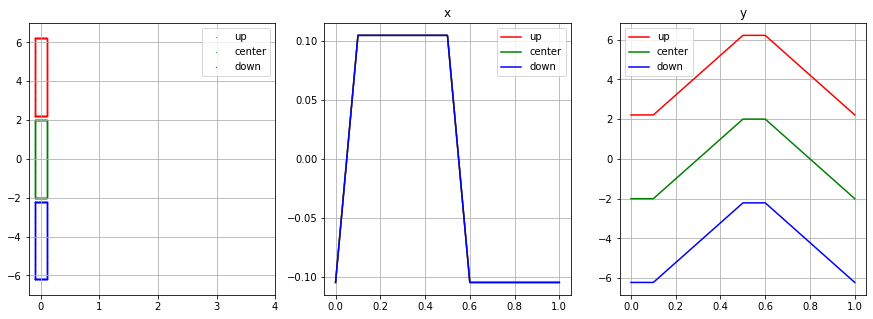

In [13]:
#
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#
s = 0.1
ax = fig.add_subplot(131)
plt.scatter(df[("up","x")], df[("up","y")], color= "red",label="up",s=s)
plt.scatter(df[("center","x")], df[("center","y")], color= "green",label="center",s=s)
plt.scatter(df[("down","x")], df[("down","y")], color= "blue",label="down",s=s)
plt.grid()
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#ax.set_aspect('equal')

#
ax = fig.add_subplot(132)#, projection='3d')
ax.plot(df["t"],df[("up","x")],color="red",label="up")
ax.plot(df["t"],df[("center","x")],color="green",label="center")
ax.plot(df["t"],df[("down","x")],color="blue",label="down")
plt.grid(True)
plt.legend()
plt.title("x")

#
ax = fig.add_subplot(133)#, projection='3d')
ax.plot(df["t"],df[("up","y")],color="red",label="up")
ax.plot(df["t"],df[("center","y")],color="green",label="center")
ax.plot(df["t"],df[("down","y")],color="blue",label="down")
plt.grid(True)
plt.legend()
plt.title("y")


plt.show()

### Stiffness Matrix

files/BEM/Young-2/stiffness_matrix-P=1-N=10-k=30.csv


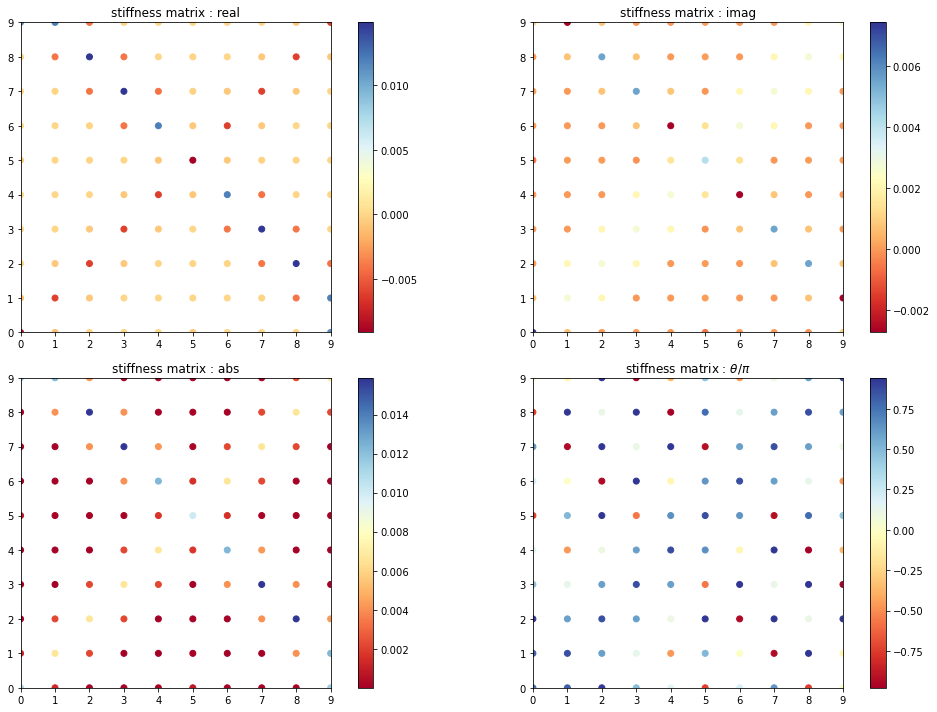

In [14]:
READ = True
SAVE = True

#names = ["up","center","down"]
opts = {"print":True,"N":[6],"ready_sm_BEM":True,"return_both":False}
#sm = [None,None,None]

#for b,n,i in zip(bs,names,[0,1,2]):    
    
file = file_dir+"stiffness_matrix-"+ suffixPNK+".csv"
file_png = file_dir+"stiffness_matrix-"+suffixPNK +".png"

print(file)

if os.path.exists(file) and READ == True :
    sm = bs.load("sm-BEM",file)
else :
    sm = bs.stiffness_matrix_BEM(k=wavevector,opts=opts)

    if SAVE == True :
        bs.save("sm-BEM",file)

plot_matrix(sm,file_png)

### Single Layer Potential basis

In [15]:
Nx= 100#int(xmax-xmin)*10
Ny = 50#int(ymax-ymin)*10
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

r = [r0,r1,r2]

for t in r:
    t = np.asarray(t)
    bs.traslate_cp(t)
    internal = bs.internal_points(XY=XY,NN=1000,xmin=0.,xmax=1.,opts=None)
    XY = XY[ np.logical_not(internal) ]
    bs.traslate_cp(-t)
    
print(len(XY))

4790


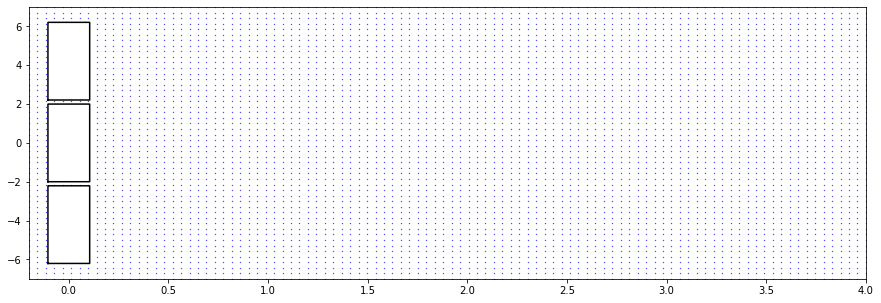

In [16]:
#
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )
#
ax = fig.add_subplot(111)
plt.plot(df[("up","x")], df[("up","y")], color= "black",label="up")
plt.plot(df[("center","x")], df[("center","y")], color= "black",label="center")
plt.plot(df[("down","x")], df[("down","y")], color= "black",label="down")
plt.scatter(XY[:,0],XY[:,1], color= "blue",label="points",s=0.1)
#plt.grid()
#plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#ax.set_aspect('equal')
plt.show()

In [ ]:
READ = True
SAVE = True

#names = ["up","center","down"]
opts = {"print":True,"N":[6]}#,"equal":[ [(0,0),(1,1)] , [(0,0),(2,2)] , [(0,1),(1,2)] ]}

#for b,n,i in zip(bs_arr,names,[0,1,2]):
        
file = file_dir+"single_layer_potential-"+suffixPNK + ".csv"

print(file)

if os.path.exists(file) and READ == True :
    print("reading file ",file)
    slp = bs.load("slp-BEM",file)

slp = bs.single_layer_potential_basis_BEM(XY=XY,k=wavevector,opts=opts)    

if SAVE == True :
    bs.save("slp-BEM",file)

slp.head()    

files/BEM/Young-2/single_layer_potential-P=1-N=10-k=30.csv
reading file  files/BEM/Young-2/single_layer_potential-P=1-N=10-k=30.csv
single_layer_potential_basis_BEM
Calculating "partial solution" for  4740  points


### Plane wave

#### Preparation

In [ ]:
def plane_wave(xx): # soluzione
    xx = np.asarray(xx)
    theta = np.dot(xx,k_in)
    return np.exp(I*theta)

In [ ]:
df[("up","z")]     = plane_wave(df[[("up","x"),("up","y")]])
df[("center","z")] = plane_wave(df[[("center","x"),("center","y")]])
df[("down","z")]   = plane_wave(df[[("down","x"),("down","y")]])
df  = df[ [("up","x")     , ("up","y")    ,("up","z")    ,\
          ("center","x") , ("center","y"),("center","z"),\
          ("down","x")   , ("down","y")  ,("down","z")]  ]
df.head()

In [ ]:
#
fig = plt.figure ( 0 , figsize = ( 15, 10 ) )

##########################################
ax = fig.add_subplot(231, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.real(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.real(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.real(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("real")

#
ax = fig.add_subplot(234, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.imag(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.imag(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.imag(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("imag")

##########################################
ax = fig.add_subplot(232, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.real(df[("up","z")])    ,color= "red",label="up")
ax.plot(df[("center","x")],df[("center","y")],np.real(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.real(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("real")

#
ax = fig.add_subplot(235, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.imag(df[("up","z")])    ,color= "red",label="up")
ax.plot(df[("center","x")],df[("center","y")],np.imag(df[("center","z")]),color= "green",label="center")
#ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.imag(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("imag")

##########################################
ax = fig.add_subplot(233, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.real(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.real(df[("center","z")]),color= "green",label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.real(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("real")

#
ax = fig.add_subplot(236, projection='3d')
ax.plot(df[("up","x")]    ,df[("up","y")]    ,0 ,color= "black")#,label="up")
ax.plot(df[("center","x")],df[("center","y")],0 ,color= "black")#,label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,0 ,color= "black")#,label="down")

#ax.plot(df[("up","x")]    ,df[("up","y")]    ,np.imag(df[("up","z")])    ,color= "red",label="up")
#ax.plot(df[("center","x")],df[("center","y")],np.imag(df[("center","z")]),color= "green",label="center")
ax.plot(df[("down","x")]  ,df[("down","y")]  ,np.imag(df[("down","z")])  ,color= "blue",label="down")
plt.grid(True)
plt.legend()
plt.title("imag")

plt.show()

In [ ]:
def plot(fig,n,xB,yB,x,y,c,title,cmap):
    
    ax = fig.add_subplot(n)
    ax.scatter(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    #ax.set_aspect('equal')
    #plt.xlim(min(x),max(x))
    #plt.ylim(min(y),max(y))
    plt.title(title)
    
    return

In [ ]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

Uinc = plane_wave(XY)

cmap = 'RdYlBu'

x = np.concatenate((np.asarray(df[("up","x")]),\
                    np.asarray(df[("center","x")]),\
                    np.asarray(df[("down","x")])))

y = np.concatenate((np.asarray(df[("up","y")]),\
                    np.asarray(df[("center","y")]),\
                    np.asarray(df[("down","y")])))
    
plot(fig,131,x,y,XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,132,x,y,XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)
plot(fig,133,x,y,XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs",cmap)

plt.show()

#### Solution

In [ ]:
file_sol = file_dir+"solution-plane_wave-"+suffixPNK+".csv"
file_lv  = file_dir+"load_vector-plane_wave-"+suffixPNK+".csv"
file_ind = file_dir+"indirect_solution-plane_wave-"+suffixPNK+".csv"
print(file_sol)
print(file_lv)
print(file_ind)

In [ ]:
opts = {"print":True,"N":[6],"equal":[ [(0,0),(1,1)] , [(0,0),(2,2)] , [(0,1),(1,2)] ]}

bs_arr = [bs.copy(),bs.copy(),bs.copy()]
bs_arr[0].traslate_cp(r0)
bs_arr[1].traslate_cp(r1)
bs_arr[2].traslate_cp(r2)

In [ ]:
#opts = {"print":False}
SLP,Xnp,Valnp = Bs.BEM_disconnected(bs=bs_arr,uinc=plane_wave,k=wavevector,XY=XY,opts=opts)

In [ ]:
Valnp.shape

In [ ]:
file = file_dir+"solution-plane_wave-"+suffixPNK+".csv"
SLP.to_csv(file,index_label="index")

In [ ]:
file = file_dir+"SM-plane_wave-"+suffixPNK+".csv"
Bs._sm_BEM_disc.to_csv(file,index_label="index")

In [ ]:
file = file_dir+"LV-plane_wave-"+suffixPNK+".csv"
Bs._lv_BEM_disc.to_csv(file,index_label="index")

In [ ]:
#
Uinc = plane_wave(XY)#.reshape(Nx,Ny).transpose()
total = Uinc + Valnp

In [ ]:
#
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

x = [np.asarray(df[("up","x")]),\
                    np.asarray(df[("center","x")]),\
                    np.asarray(df[("down","x")])]

y = [np.asarray(df[("up","y")]),\
                    np.asarray(df[("center","y")]),\
                    np.asarray(df[("down","y")])]
    
plot_sol_disc(fig,331,x,y,XY[:,0],XY[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot_sol_disc(fig,334,x,y,XY[:,0],XY[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)
plot_sol_disc(fig,337,x,y,XY[:,0],XY[:,1],np.absolute(Uinc),"$u_{inc}$ : abs",cmap)

plot_sol_disc(fig,332,x,y,XY[:,0],XY[:,1],Valnp.real,"$u_{scat}$ : real",cmap)
plot_sol_disc(fig,335,x,y,XY[:,0],XY[:,1],Valnp.imag,"$u_{scat}$ : imag",cmap)
plot_sol_disc(fig,338,x,y,XY[:,0],XY[:,1],np.absolute(Valnp),"$u_{scat}$ : abs",cmap)

plot_sol_disc(fig,333,x,y,XY[:,0],XY[:,1],total.real,"$u_{tot}$ : real",cmap)
plot_sol_disc(fig,336,x,y,XY[:,0],XY[:,1],total.imag,"$u_{tot}$ : imag",cmap)
plot_sol_disc(fig,339,x,y,XY[:,0],XY[:,1],np.absolute(total),"$u_{tot}$ : abs",cmap)

plt.show()